# Ethan Holand HW3 Problem 1

In [72]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [73]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

## Evaluation Functions

In [74]:
def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['tnr'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['fpr'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['fnr'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['tpr'] = len(ind_11) / N_labels[1]

    return class_metrics

## Classifiers

In [75]:
# ERM classification rule (min prob. of error classifier)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

## Generate data

[2555 2488 2428 2529]


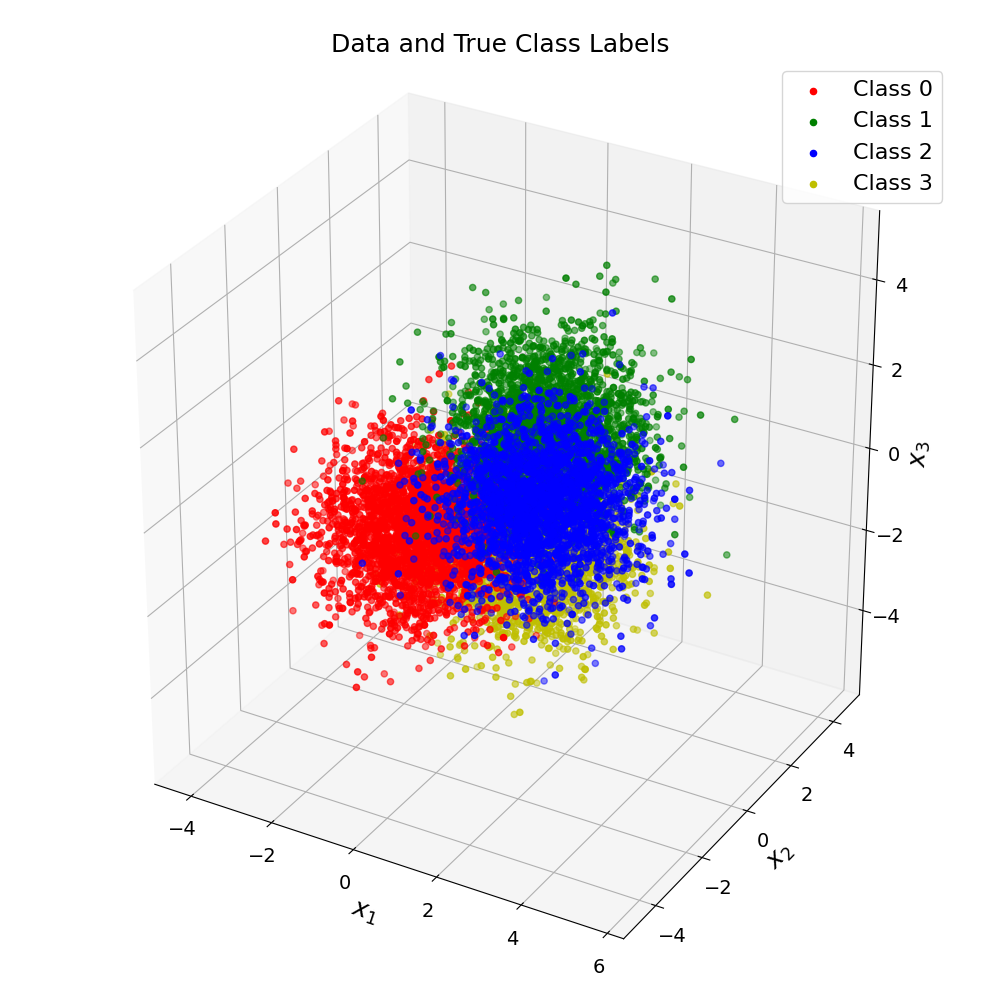

In [76]:
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.25, 0.25, 0.25, 0.25])
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['m'] = np.array([[-1, -1, -1],
                         [1, 1, 1],
                         [2, -1, 0.5],
                         [0.5, 1, -2]])  # Gaussian distributions means
gmm_pdf['C'] = np.array([[[1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]],
                         [[1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]],
                          [[1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]],
                          [[1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]],])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax_raw = fig.add_subplot(111, projection='3d')

X, labels = generate_data_from_gmm(N, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))
C = np.size(L)

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r', label="Class 0")
ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='g', label="Class 1")
ax_raw.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='b', label="Class 2")
ax_raw.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='y', label="Class 3")
ax_raw.set_xlabel(r"$x_1$")
ax_raw.set_ylabel(r"$x_2$")
ax_raw.set_zlabel(r"$x_3$")
# Set equal axes for 3D plots
ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

In [77]:
# Create coordinate matrices determined by the sample space
# xx, yy, zz = np.meshgrid(np.linspace(-4, 4, 250), np.linspace(-4, 4, 250), np.linspace(-4, 4, 250))

# grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

## Multilayer Neural Network

Let's now use [PyTorch](https://pytorch.org/) and put together an MLP that will be capable of separating the classes irrespective of the input's non-linearly separable space.

To begin with, we'll define an MLP class that consists of a single hidden layer (2-layer architecture altogether) with a ReLU activation function:

In [78]:
input_dim = X.shape[1]
n_hidden_neurons = 16 # <-- vary this
output_dim = C

# It's called an MLP but really it's not...
model = nn.Sequential(
    nn.Linear(input_dim, n_hidden_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, output_dim),
    nn.LogSoftmax(dim=1)
)
# Visualize network architecture
print(model)

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
  (3): LogSoftmax(dim=1)
)


Another useful package [torchsummary](https://github.com/sksq96/pytorch-summary) to visualize the neural network architecture:

In [79]:
summary(model, input_size=(16, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]              64
              ReLU-2               [-1, 16, 16]               0
            Linear-3                [-1, 16, 4]              68
        LogSoftmax-4                [-1, 16, 4]               0
Total params: 132
Trainable params: 132
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [80]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model


# Stochastic GD with learning rate and momentum hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
# the output when validating, on top of calculating the negative log-likelihood using 
# nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
criterion = nn.CrossEntropyLoss()
num_epochs = 100

# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(labels)

# Trained model
model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)

Find the probability of error:

In [81]:
def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)
# Z matrix are the predictions resulting from the forward pass through the network
Z = model_predict(model, X_tensor)

In [82]:
# ERM decisions:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

print("Confusion Matrix for MAP (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated MAP Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix for MAP (rows: Predicted class, columns: True class):
[[2222   59   79  179]
 [  62 2000  288  139]
 [  73  310 2008   58]
 [ 198  119   53 2153]]
Total Mumber of Misclassified Samples: 1617
Empirically Estimated MAP Probability of Error: 0.1617


In [83]:
print("Confusion Matrix for MLP (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(Z, labels)
print(conf_mat)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated MLP Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix for MLP (rows: Predicted class, columns: True class):
[[2230   65   88  186]
 [  57 1981  286  123]
 [  71  307 1986   54]
 [ 197  135   68 2166]]
Total Mumber of Misclassified Samples: 1637
Empirically Estimated MLP Probability of Error: 0.1637
